In [6]:
import pandas as pd
%matplotlib inline
import duplicatesuricate.deduplication as dep
from duplicatesuricate.preprocessing import clean_db

In [3]:
df=pd.read_csv('gid_withpossiblematches_2POR.csv',dtype={'duns':str,'postalcode':str},sep=',',index_col=0,encoding='utf-8',nrows=5000)
df.drop(['latlng'],axis=1,inplace=True)
df.rename(columns={'possiblematches':'gid'},inplace=True)
for x in [df]:
    x = clean_db(x)
df.sample(3)

print('nrows: {}'.format(df.shape[0]))
print(df.dtypes)

df.sample(3)

nrows: 5000
gid                     int64
name                   object
duns                   object
city                   object
postalcode             object
state                  object
street                 object
country_code           object
name_wostopwords       object
street_wostopwords     object
name_acronym           object
postalcode_1stdigit    object
postalcode_2digits     object
name_len                int64
hasairbusname           int64
isbigcity               int64
dtype: object


,gid,name,duns,city,postalcode,state,street,country_code,name_wostopwords,street_wostopwords,name_acronym,postalcode_1stdigit,postalcode_2digits,name_len,hasairbusname,isbigcity
gid,,,,,,,,,,,,,,,,
b2e57bed-f2f8-4023-808e-cd47584685f9,2313,rs components g10192580,None,morfelden walldorf,64546,hesse,13b hessenring,DE,rs components g10192580,hessenring 13b,rcg,6,64,23,0,0
beebfd94-5922-4751-80b1-eab2fcb36560,809,regierung von oberbayern,None,munich,80000,bavaria,130 hestr,DE,regierung von oberbayern,he 130,rvo,8,80,24,0,1
2c84601c-5418-478d-ae47-6dbc1fa06806,1862,heatherside engineering limited,73415878,arlesey,sg15 6xd,england,old oak close,GB,heatherside,oak close old,hel,s,sg,31,0,0


## with help of a classifier

The classifier will identify possible matches, ranked by their probabilities, and thus we might be able to train it on the decision frontier

In [4]:
scoredict={'fuzzy':['city','name','street'],
          'exact':['duns','postalcode','country_code','postalcode_2digits'],
          'token':['name_wostopwords','street_wostopwords']}
traincols=dep._transform_scoredict_scorecols(scoredict)[1]
training_table=pd.read_csv('trainining_table3.csv',sep=',',index_col=[0,1],usecols=['ix_source','ix_target']+traincols+['y_true'])
classifier = dep.ScikitLearnClassifier()
X_train = training_table.iloc[:,:-1].astype(float)
y_train= training_table.iloc[:,-1].astype(int)
classifier.fit(X=X_train,y=y_train)
filterdict={'all':['country_code'],
           'any':['duns']}
intermediate_thresholds={'name_wostopwords_fuzzyscore':0.5,'street_wostopwords_fuzzyscore':0.5, 'duns_exactscore':1.0,'aggfunc':'any'}
sur=dep.Suricate(input_records=df,target_records=df,
                 filterdict=filterdict,
                 intermediate_thresholds=intermediate_thresholds,
                 classifier=classifier)

shape of training table  (3770, 9)
number of positives in table 1389
precision score on training data: 0.977385159011
recall score on training data: 0.995680345572
time elapsed 6.64543 seconds


#### Launch the deduplication to obtain most probable matches
We want to capture bad matches as well as good matches to train the model, so we get the probability vector

In [5]:
res=sur.start_linkage(sample_size=50,n_matches_max=5,with_proba=True)
res=res.loc[res['ix_source']!=res['ix_target']]res.head()

starting deduplication at 2018-02-13 16:43:05.178112
1 of 50 inputs records deduplicated | found 5 of 5 max possible matches | time elapsed 0.568201 s
2 of 50 inputs records deduplicated | found 2 of 5 max possible matches | time elapsed 0.507747 s
3 of 50 inputs records deduplicated | found 2 of 5 max possible matches | time elapsed 0.505667 s
4 of 50 inputs records deduplicated | found 1 of 5 max possible matches | time elapsed 1.230556 s
5 of 50 inputs records deduplicated | found 4 of 5 max possible matches | time elapsed 0.494578 s
6 of 50 inputs records deduplicated | found 4 of 5 max possible matches | time elapsed 0.526477 s
7 of 50 inputs records deduplicated | found 4 of 5 max possible matches | time elapsed 0.599716 s
8 of 50 inputs records deduplicated | found 4 of 5 max possible matches | time elapsed 0.679556 s
9 of 50 inputs records deduplicated | found 2 of 5 max possible matches | time elapsed 0.496225 s
10 of 50 inputs records deduplicated | found 2 of 5 max possible 

#### reformat the results table to:
- remove matches on the same record (ix_source = A , ix_target=A)
- remove duplicates of the same pair ((ix_source =A,ix_target=B) & (ix_source=B,ix_target=A))

In [9]:
print(res.shape[0])

# remove matches on the same record
res=res.loc[res['ix_source']!=res['ix_target']]
print(res.shape[0])

# remove duplicate matches on the pair record
res['pairs']=res.apply(lambda r:' '.join(r[['ix_source','ix_target']].sort_values(ascending=True).tolist()),axis=1)
res.drop_duplicates(subset=['pairs'],inplace=True)
res.drop('pairs',axis=1,inplace=True)
print(res.shape[0])

125
125
82


#### Calculate y_true
If the two matches share the same group id , it is a good match, otherwise not

In [11]:
res['gid_source']=df.loc[res['ix_source'].values,'gid'].values
res['gid_target']=df.loc[res['ix_target'].values,'gid'].values
res['y_true']=(res['gid_source']==res['gid_target']).astype(int)

#### Highlight disagreements between manual classification and the classifier

In [26]:
res['y_pred']=(res['y_proba']>0.5).astype(int)
res['iscorrect']=(res['y_true']==res['y_pred'])

What do the results look like

1    57
0    25
Name: y_true, dtype: int64


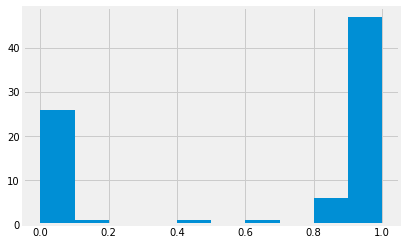

In [31]:
print(res['y_true'].value_counts())
res['y_proba'].hist();

#### Format the results

In [14]:
comparison=sur.build_visualcomparison_table(inputs=res['ix_source'].values,
                                 targets=res['ix_target'].values,
                                 display=['name','street','city','postalcode','duns','country_code'],
                                 exact=['duns'],
                                 y_proba=res['y_proba'].values,
                                 y_true=res['y_true'].values)
comparison.sort_values(by='y_proba',ascending=True,inplace=True)

In [32]:
res2=res.set_index(['ix_source','ix_target'],drop=True)[['y_pred','iscorrect']]
comparison=comparison.join(res2,how='left')

### Output
the data is fit for manual checking and training the classifier!

In [33]:
comparison.sample(3)

,,name_source,name_target,country_code_source,country_code_target,street_source,street_target,duns_source,duns_target,duns_exactscore,postalcode_source,postalcode_target,city_source,city_target,y_proba,y_true,y_pred,iscorrect
ix_source,ix_target,,,,,,,,,,,,,,,,,
d4468f99-877a-4772-8826-bb1d24f88ec7,134e55ca-a655-4d9d-b997-77bffdca9bd9,le manoir de gressy,manoir de gressy,FR,FR,chemin des carrosses,chemin des carrosses,None,None,0.0,77410,77410,gressy,gressy,0.985560,1,1,True
b8e81c89-45bf-477e-ac25-3c20ae97be3c,7c7ed72b-6006-4c04-85f4-ed47466e9deb,le manoir de gressy,le manoir de gressy,FR,FR,2 rue saint denis,2 rue saint denis,None,None,0.0,77410,77410,gressy,gressy,0.984145,1,1,True
a9246643-2d3e-4bfa-8d8d-42da289f2e00,fb84d8cd-faf3-463b-8754-a18eb73e5d20,muenchner knoedelei,gebrueder schneider gmbh,DE,DE,51 lilienstr,51 lindenstr,342593012,316937473,-1.0,81669,57627,munich,hachenburg,0.000000,0,0,True
